In [1]:
import pandas as pd
import json
import re
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

# Load NLTK stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Load JSON data
with open('../data/processed/UN_data.json', 'r') as file:
    data = json.load(file)

# Convert JSON data to DataFrame
articles = pd.DataFrame(data)

def preprocess_text(text):
    text = re.sub('[,\.!?]', '', text)
    text = text.lower()
    return text

articles['text_processed'] = articles['text'].apply(preprocess_text)

# Tokenize and remove stopwords
def remove_stopwords(texts):
    return [" ".join([word for word in re.findall(r'\b\w+\b', doc) if word not in stop_words]) for doc in texts]

data = articles['text_processed'].values.tolist()
data_processed = remove_stopwords(data)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritutoshniwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Initialize the BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(data_processed, show_progress_bar=True)

# Convert to NumPy array
embeddings = np.array(embeddings)
print(f"Embeddings shape: {embeddings.shape}")

Batches: 100%|██████████| 36/36 [00:11<00:00,  3.15it/s]

Embeddings shape: (1138, 384)


In [3]:
import umap

# Reduce to 2D or 5D for visualization and clustering
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine', 
                            random_state=42).fit_transform(embeddings)
print(f"UMAP embeddings shape: {umap_embeddings.shape}")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP embeddings shape: (1138, 5)


In [4]:
import hdbscan

# Cluster the UMAP embeddings
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, 
                            metric='euclidean', 
                            cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(umap_embeddings)

print(f"Number of clusters found: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")

Number of clusters found: 7


In [5]:
from sklearn.cluster import KMeans

# Define the number of clusters
num_clusters = 5

# Cluster with KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
# Using KMeans labels (if you used KMeans)
articles['cluster'] = kmeans_labels

In [12]:
# countries with coalition of the willing
coalition_of_willing_countries_list = ["United States",
    "Afghanistan", "Albania", "Australia", "Azerbaijan", "Bulgaria", "Colombia",
    "Czechia", "Denmark", "El Salvador", "Eritrea", "Estonia", "Ethiopia",
    "Georgia", "Hungary", "Iceland", "Italy", "Japan", "Korea, Republic of", "Latvia",
    "Lithuania", "North Macedonia", "Netherlands", "Nicaragua", "Philippines", "Poland",
    "Romania", "Slovakia", "Spain", "Türkiye", "United Kingdom", "Uzbekistan",
    "Costa Rica", "Dominican Republic", "Honduras", "Kuwait", "Marshall Islands",
    "Micronesia, Federated States of", "Mongolia", "Palau", "Portugal", "Rwanda", "Singapore",
    "Solomon Islands", "Uganda", "Panama", "Angola", "Tonga", "Ukraine"
]
import pycountry
countries = articles['country'].unique()
country_names = {country.alpha_3: country.name for country in pycountry.countries}
#add country names to the data
articles['country_name'] = articles['country'].map(country_names)

In [14]:
#add column called coalition_of_willing, if the country is in the list, then it is part of the coalition
articles['coalition_of_willing'] = articles['country_name'].isin(coalition_of_willing_countries_list)
articles.head()
# Replace coalition_of_willing with 1 and 0
articles['coalition_of_willing'] = articles['coalition_of_willing'].astype(int)
articles.head()

#add to the lda_weights_df
articles['coalition_of_willing'] = articles['coalition_of_willing']

In [15]:
articles.head()

,session,year,country,text,label,text_processed,cluster,country_name,coalition_of_willing
0,57,2002,PAN,﻿Allow me\nto begin my statement by expressing...,135,﻿allow me\nto begin my statement by expressing...,1,Panama,1
1,57,2002,IND,﻿I\ncongratulate Mr. Kavan on his election as ...,77,﻿i\ncongratulate mr kavan on his election as p...,1,India,0
2,57,2002,MDV,"﻿Mr. President, it gives\nme great pleasure to...",110,﻿mr president it gives\nme great pleasure to j...,1,Maldives,0
3,57,2002,DJI,﻿In a year\nof frightful tragedy and uncertain...,45,﻿in a year\nof frightful tragedy and uncertain...,1,Djibouti,0
4,57,2002,NLD,"﻿The smoke\nat ground zero, only a few blocks ...",128,﻿the smoke\nat ground zero only a few blocks a...,4,Netherlands,1


In [18]:
articles['coalition_of_willing'].value_counts()

coalition_of_willing
0    845
1    293
Name: count, dtype: int64

In [16]:
import pandas as pd

# Group by 'cluster' and count 'coalition_of_willing'
cluster_label_counts = articles.groupby('cluster')['coalition_of_willing'].value_counts().unstack(fill_value=0)

# Rename columns for clarity
cluster_label_counts.columns = [0, 1]

print(cluster_label_counts)

           0   1
cluster         
0        221  27
1        174  80
2        144  41
3        165  93
4        141  52


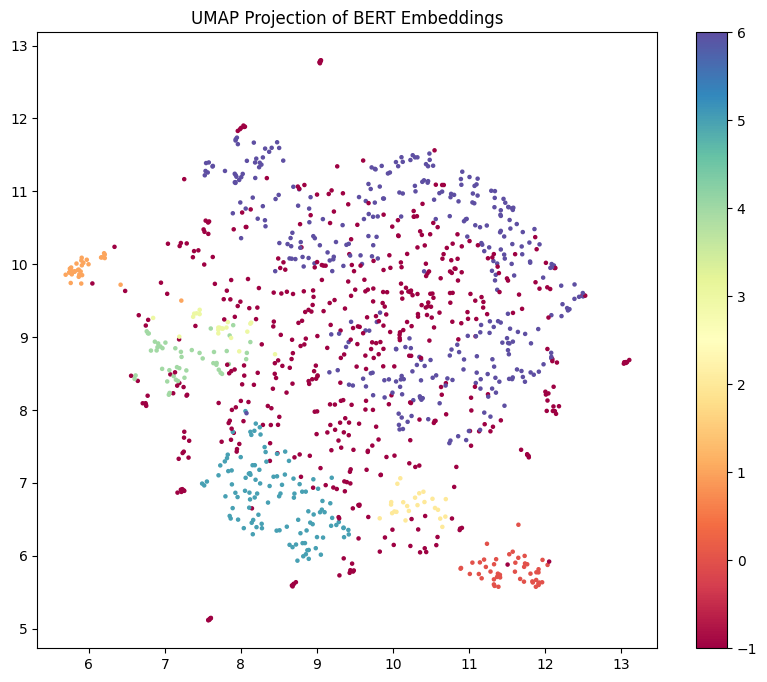

In [7]:
import matplotlib.pyplot as plt

# If UMAP embeddings are 2D, you can plot them directly
umap_2d = umap.UMAP(n_neighbors=15, 
                    n_components=2, 
                    metric='cosine', 
                    random_state=42).fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=cluster_labels, cmap='Spectral', s=5)
plt.colorbar()
plt.title('UMAP Projection of BERT Embeddings')
plt.show()

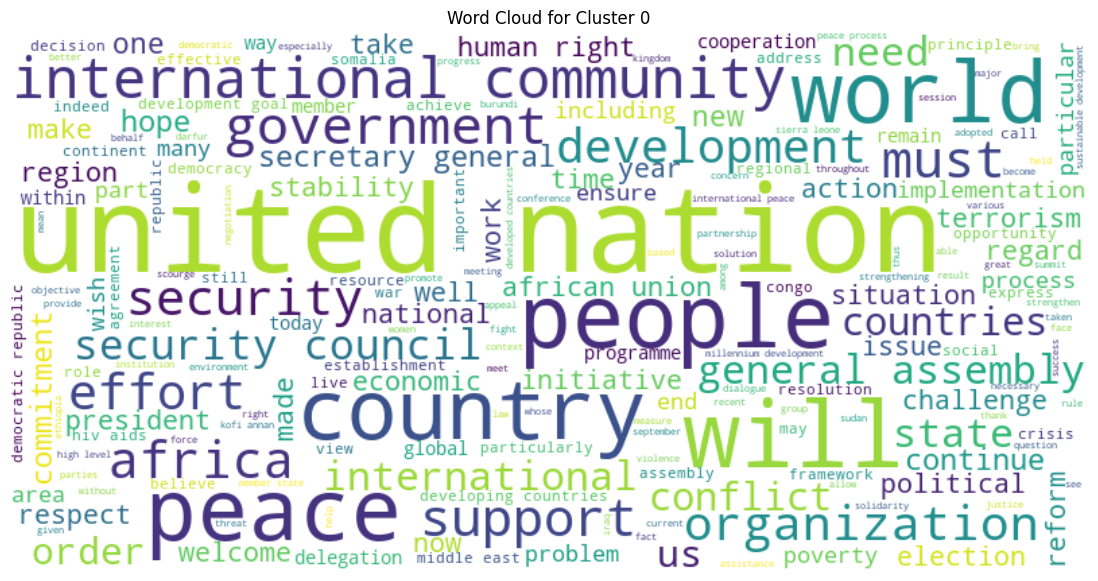

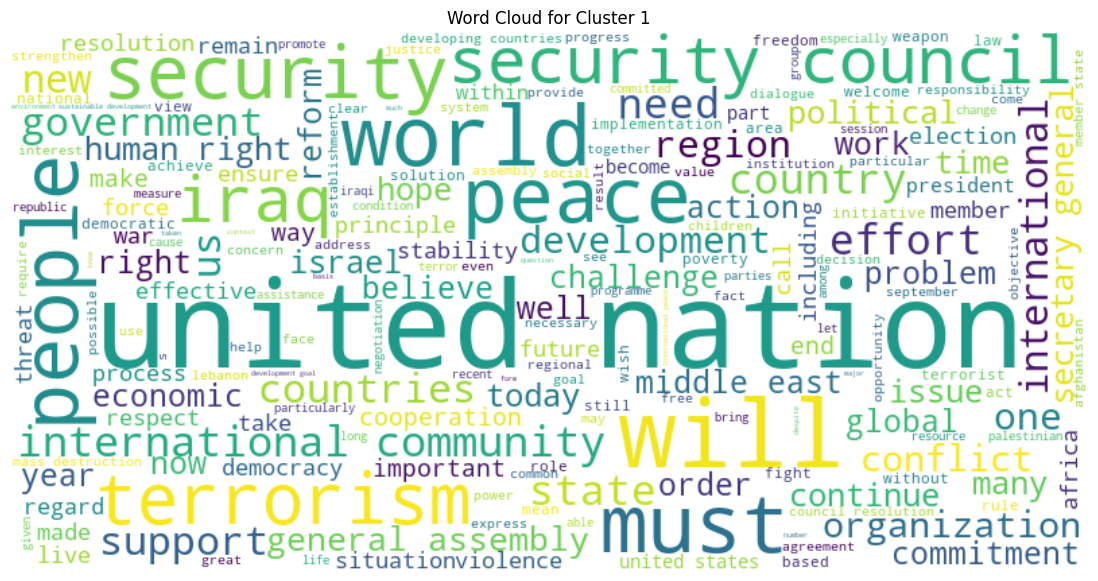

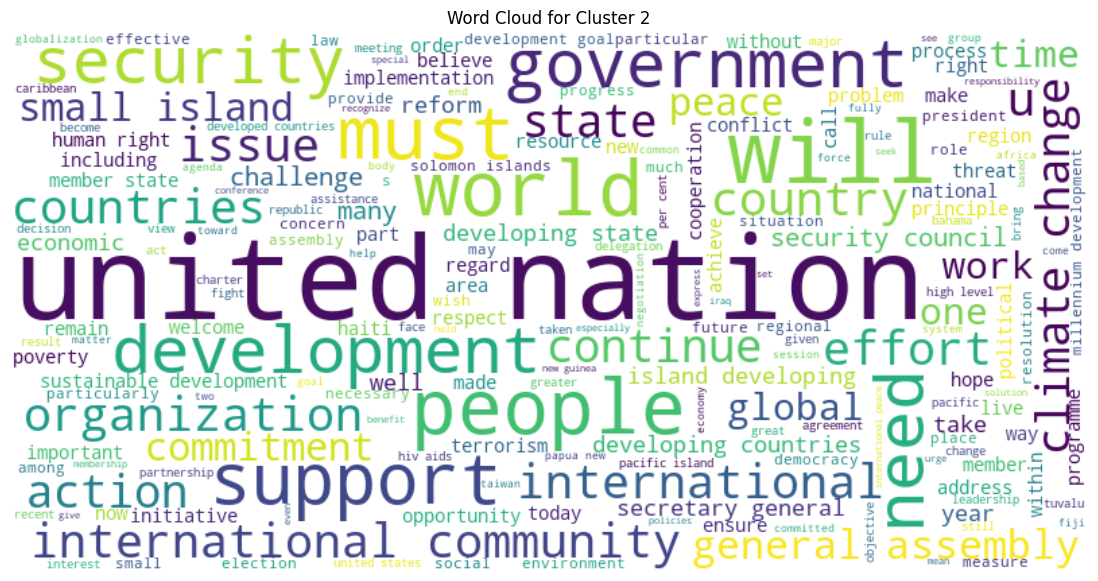

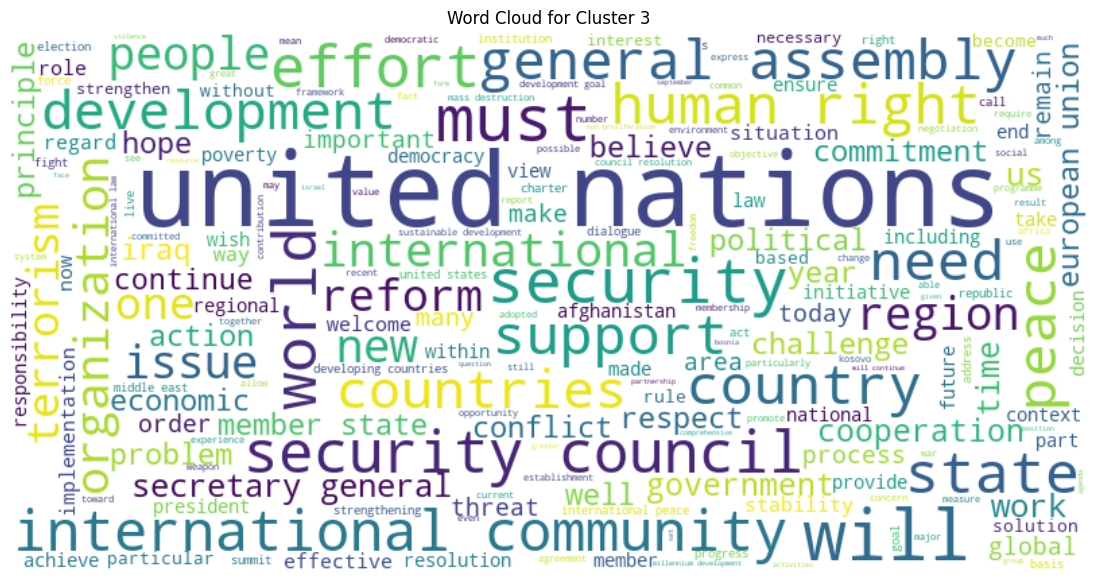

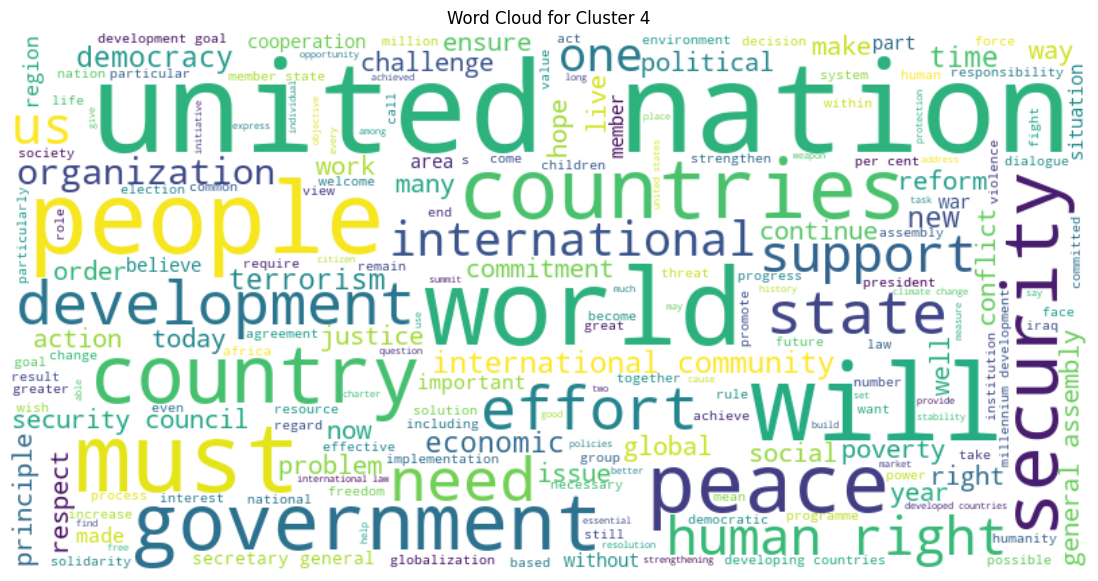

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [10]:
from wordcloud import WordCloud

def plot_word_cloud(cluster_number):
    cluster_docs = articles[articles['cluster'] == cluster_number]['text_processed']
    text = ' '.join(cluster_docs)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_number}')
    plt.show()

# Plot word clouds for each cluster
for cluster_num in set(cluster_labels):
        plot_word_cloud(cluster_num)